In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib_inline.backend_inline as backend_inline
from torchsummary import summary

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [3]:
# Create Gaussian blurs with varying widths and occluding bars
nGauss = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# Vary the width smoothly
widths = np.linspace(2, 20, nGauss)

# Initialize tensor containing Gaussian blur images
images = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):
    # Create Gaussian blur
    ro = 1.5 * np.random.randn(2) # ro => Random offset
    G = np.exp(-((X - ro[0])**2 + (Y - ro[1])**2) / (widths[i]))

    # And add some noise
    G = G + np.random.randn(imgSize, imgSize) / 5

    # Add random bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))

    if np.random.randn() > 0:
        G[i1 : i1 + i2,] = 1
    else:
        G[:, i1 : i1 + i2] = 1

    # Add to the tensor images
    images[i, : , : , :] = torch.tensor(G).view(1, imgSize, imgSize)

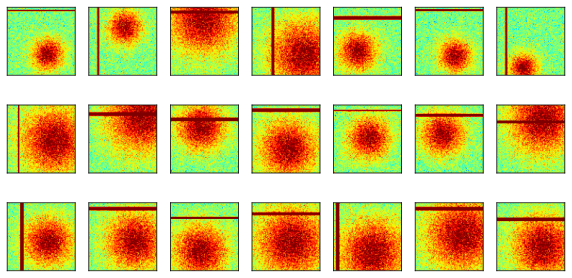

In [5]:
# visualize some images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [6]:
# Create the CNN Autoencoder model
def create_model():
    class CNN_AE_Gauss(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoder
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.conv2d(6, 4, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )

            # Decoder
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2),
            )
        def forward(self, x):
            x = self.enc(x)
            x = self.dec(x)
            return x
        
    # Model instance
    net = CNN_AE_Gauss().to(device)

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    # Loss function
    lossFun = nn.MSELoss()

    return net, optimizer, lossFun
